# Imports

In [1]:
import pickle
import time
from pathlib import Path

import jax
import numpy as np
import optax
import pandas as pd
from flax import linen as nn
from flax import serialization
from flax.training import train_state
from jax import numpy as jnp
from jax import random
from matplotlib import cm
from matplotlib import pyplot as plt

# Helpers

In [2]:
class MLP(nn.Module):
    widths: list[int]

    @nn.compact
    def __call__(self, x):
        for i, w in enumerate(self.widths):
            x = nn.Dense(w)(x)
            if i != len(self.widths) - 1:
                x = nn.tanh(x)
        return x

# Parameters

In [3]:
xmin = 0.0
xmax = 10.0

tmin = 0.0
tmax = 0.5
umax = 1.0

In [4]:
μ = 100e3
d0 = 0.1
m = 0.02

# Scaling

In [5]:
# Don't change `L` and `T`.
# BC inforcement in the model, assumes them as given below,
# e.g. it is assumed that x0 = t0 = 0 and x1 = t1 = 1.
L = xmax - xmin
T = tmax - tmin
U = umax
Γ = U / L
Σ = 100

In [6]:
x0 = xmin / L
x1 = xmax / L
t0 = tmin / T
t1 = tmax / T

# Seed

In [7]:
key = random.key(0)

2024-08-12 16:25:50.282149: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Model

In [8]:
class Module(nn.Module):
    hidden_width: int
    num_hidden_layers: int

    @nn.compact
    def __call__(self, X):
        widths = [self.hidden_width] * self.num_hidden_layers + [2]
        u, γp = MLP(widths)(X)

        t, x = X[:2]
        u = t * x * (1 - x) * u + t * x * umax / U
        γp *= t

        return u, γp

In [9]:
module = Module(64, 3)

# Loss function

In [10]:
def loss_fn(params, state, X):
    def loss_per_sample(x):
        S0 = x[2] * Σ
        _, γp = state.apply_fn({"params": params}, x)
        γp *= Γ
        du_fn = jax.grad(lambda x: state.apply_fn({"params": params}, x)[0])
        du_dx = du_fn(x)[1] * U / L
        d2u_dx2 = jax.grad(lambda x: du_fn(x)[1])(x)[1] * U / L**2
        dγp = jax.grad(lambda x: state.apply_fn({"params": params}, x)[1])(x)
        γpdot, dγp_dx = dγp[0] * Γ / T, dγp[1] * Γ / L

        dp = jnp.abs(γpdot)

        macro_loss = μ * (d2u_dx2 - dγp_dx) / S0
        micro_loss = (μ * (du_dx - γp) - S0 * (dp / d0) ** m * jnp.sign(γpdot)) / S0

        return macro_loss**2 + micro_loss**2

    return jnp.mean(jax.vmap(loss_per_sample)(X))

# Training points

In [11]:
# Grid points
# Avoid boundaries by a small margin
ε = 1e-7

S00 = 10 / Σ
S01 = 1000 / Σ

nx = 30
nt = 100
nS0 = 30

xs = jnp.linspace(x0+ε, x1-ε, nx)
ts = jnp.linspace(t0+ε, t1-ε, nt)
S0s = jnp.linspace(S00, S01, nS0)
tgrid, xgrid, S0grid = jnp.meshgrid(ts, xs, S0s)
X_train = jnp.column_stack([tgrid.flatten(), xgrid.flatten(), S0grid.flatten()])

S0s

Array([ 0.1       ,  0.4413793 ,  0.78275865,  1.1241379 ,  1.4655173 ,
        1.8068967 ,  2.1482759 ,  2.4896553 ,  2.8310344 ,  3.1724138 ,
        3.5137932 ,  3.8551724 ,  4.1965513 ,  4.537931  ,  4.87931   ,
        5.22069   ,  5.562069  ,  5.9034486 ,  6.2448277 ,  6.5862074 ,
        6.9275866 ,  7.2689652 ,  7.610345  ,  7.951724  ,  8.293103  ,
        8.634482  ,  8.975862  ,  9.317242  ,  9.658621  , 10.        ],      dtype=float32)

# Optimizer

In [12]:
epochs = 100
batch_size = 256
steps = epochs * len(X_train) // batch_size
steps

35156

In [13]:
lr = optax.linear_schedule(1e-2, 1e-5, steps)
tx = optax.adam(lr)

# Training state

In [14]:
class TrainState(train_state.TrainState):
    loss: float


def create_train_state(module, key, tx):
    params = module.init(key, jnp.ones(3))["params"]
    return TrainState.create(apply_fn=module.apply, params=params, tx=tx, loss=None)

In [15]:
key, subkey = random.split(key)
state = create_train_state(module, subkey, tx)

# Train step

In [16]:
@jax.jit
def train_step(state, X):
    loss, grads = jax.value_and_grad(loss_fn)(state.params, state, X)
    state = state.apply_gradients(grads=grads)
    state = state.replace(loss=loss)
    return state

# Training

In [17]:
print_every = 1000
loss_history = []

In [18]:

def dataloader(arrays, batch_size):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = np.arange(dataset_size)
    while True:
        perm = np.random.permutation(indices)
        start = 0
        end = batch_size
        while end <= dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

iter_data = dataloader((X_train,), batch_size)

In [19]:
start_time = time.time()
for step, (x,) in zip(range(steps), iter_data):
    state = train_step(state, x)
    loss_history.append(state.loss.item())
    if (step % print_every == 0) or (step == steps - 1):
        print(
            f"{step=}, train_loss={loss_history[-1]}"
        )
print(f"Training over! Time taken {time.time() - start_time} s.")

step=0, train_loss=6769.16015625
step=1000, train_loss=0.3503802418708801
step=2000, train_loss=0.2512369751930237
step=3000, train_loss=0.18126460909843445
step=4000, train_loss=0.6547291278839111
step=5000, train_loss=0.7357889413833618
step=6000, train_loss=0.26533275842666626
step=7000, train_loss=0.31750229001045227
step=8000, train_loss=0.13188818097114563
step=9000, train_loss=2.1699042320251465
step=10000, train_loss=0.4003100097179413
step=11000, train_loss=570.8236083984375
step=12000, train_loss=1.2327640056610107
step=13000, train_loss=6695.736328125
step=14000, train_loss=0.09724156558513641
step=15000, train_loss=0.06854291260242462
step=16000, train_loss=0.21375998854637146
step=17000, train_loss=0.06210571900010109
step=18000, train_loss=3.6381497383117676
step=19000, train_loss=0.9657750129699707
step=20000, train_loss=0.9185885787010193
step=21000, train_loss=0.0653582438826561
step=22000, train_loss=0.05389184132218361
step=23000, train_loss=0.06870709359645844
step=

In [20]:
save_dir = Path("/home/ankit/OneDrive/PINN_Lele/flax_scripts3/src/notebooks/saved_models/")
with open(save_dir / "params_S0_extrapolation.pickle", "wb") as f:
    pickle.dump(serialization.to_state_dict(state.params), f)

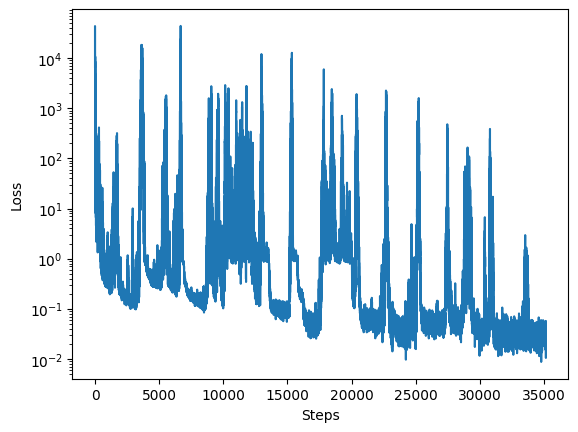

In [21]:
plt.plot(loss_history)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

# Testing

In [17]:
# Load the trained module
model_path = "/home/ankit/OneDrive/PINN_Lele/flax_scripts3/src/notebooks/saved_models/params_S0_extrapolation.pickle"
with open(model_path, "rb") as f:
    trained_dict = pickle.load(f)
key, subkey = random.split(key)
params = module.init(subkey, jnp.ones(3))["params"]
params = serialization.from_state_dict(params, trained_dict)
state = state.replace(params=params)

In [18]:
S0 = 100
n = 100

ts = jnp.linspace(t0, t1, n)
xs = jnp.linspace(x0, x1, n)
tgrid, xgrid = jnp.meshgrid(ts, xs)
tvec = tgrid.flatten()
xvec = xgrid.flatten()
X_test = jnp.column_stack([tvec, xvec, jnp.full_like(tvec, S0 / Σ)])

In [19]:
u, γp = jax.vmap(lambda x: state.apply_fn({"params": state.params}, x))(X_test)
u *= U
γp *= Γ

du = jax.vmap(jax.grad(lambda x: state.apply_fn({"params": state.params}, x)[0]))(X_test)
du_dx = du[:, 1] * U / L
τ = μ * (du_dx - γp)

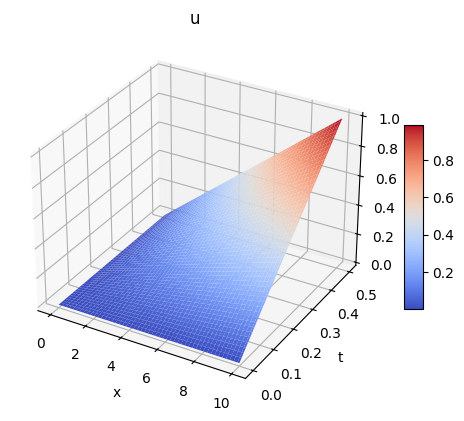

In [20]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(
    xgrid * L, tgrid * T, u.reshape(xgrid.shape), cmap=cm.coolwarm
)
plt.title("u")
plt.xlabel("x")
plt.ylabel("t")
fig.colorbar(surf, shrink=0.5, aspect=10)
# plt.savefig(rundir / "upred_over_grid.pdf")
plt.show()

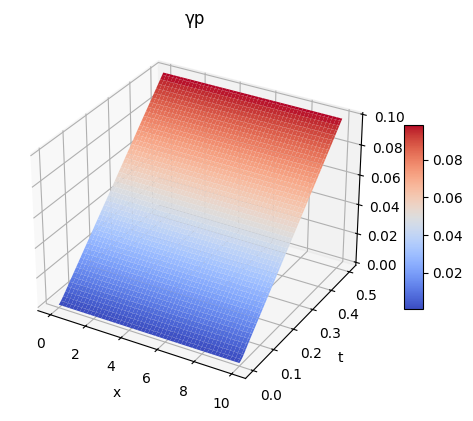

In [21]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(
    xgrid * L, tgrid * T, γp.reshape(xgrid.shape), cmap=cm.coolwarm
)
plt.title("γp")
plt.xlabel("x")
plt.ylabel("t")
fig.colorbar(surf, shrink=0.5, aspect=10)
# plt.savefig(rundir / "γppred_over_grid.pdf")
plt.show()

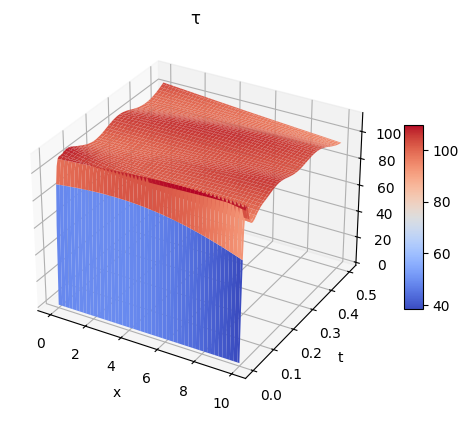

In [22]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(
    xgrid * L, tgrid * T, τ.reshape(xgrid.shape), cmap=cm.coolwarm
)
plt.title("τ")
plt.xlabel("x")
plt.ylabel("t")
# ax.set_zlim(0, 120)
fig.colorbar(surf, shrink=0.5, aspect=10)
# plt.savefig(rundir / "τpred_over_grid.pdf")
plt.show()

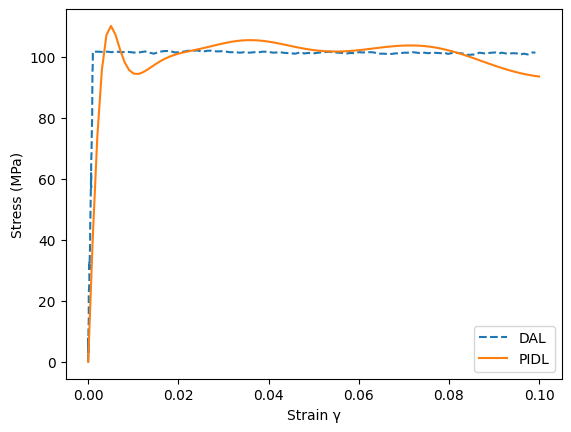

In [23]:
X_test = jnp.column_stack([ts, jnp.ones(n), jnp.full(n, S0 / Σ)])
u, γp = jax.vmap(lambda x: state.apply_fn({"params": state.params}, x))(X_test)
u *= U
γp *= Γ
du = jax.vmap(jax.grad(lambda x: state.apply_fn({"params": state.params}, x)[0]))(X_test)
du_dx = du[:, 1] * U / L
τ = μ * (du_dx - γp)
γ = u / L

df = pd.read_csv("/home/ankit/OneDrive/PINN_Lele/flax_scripts3/fem_sols/anand_1d_fig_1a_curve1.csv")
fig = plt.figure()
plt.plot(df["x"], df["Curve1"], ls="--", label="DAL")
plt.plot(γ, τ, label="PIDL")
plt.legend()
plt.xlabel("Strain γ")
plt.ylabel("Stress (MPa)")
plt.show()


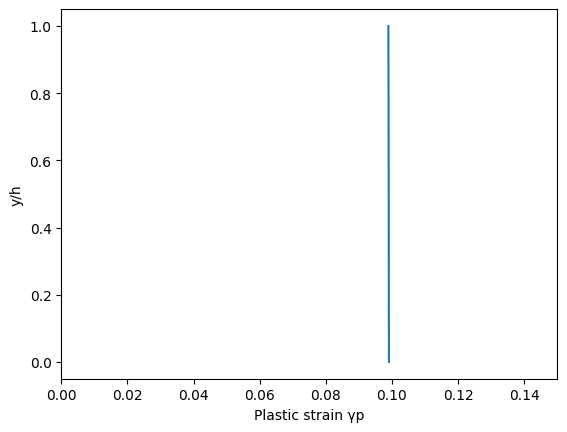

In [24]:

X_test = jnp.column_stack([jnp.ones(n), xs, jnp.full(n, S0 / Σ)])
_, γp = jax.vmap(lambda x: state.apply_fn({"params": state.params}, x))(X_test)
γp *= Γ
plt.plot(γp, xs)
plt.xlim(left=0, right=0.15)
plt.xlabel("Plastic strain γp")
plt.ylabel("y/h")
plt.show()


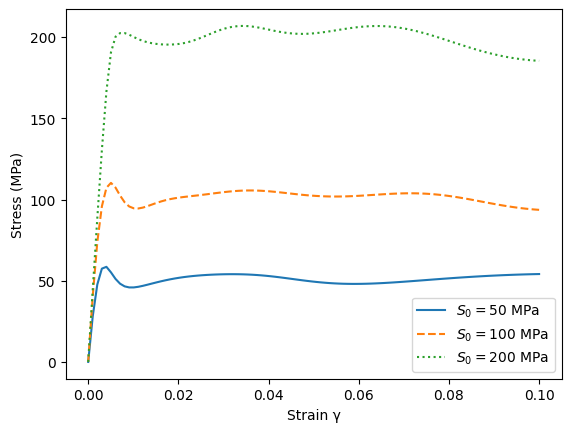

In [25]:
S0 = 50.0
X_test = jnp.column_stack([ts, jnp.ones(n), jnp.full(n, S0 / Σ)])
u, γp = jax.vmap(lambda x: state.apply_fn({"params": state.params}, x))(X_test)
u *= U
γp *= Γ
du = jax.vmap(jax.grad(lambda x: state.apply_fn({"params": state.params}, x)[0]))(X_test)
du_dx = du[:, 1] * U / L
τ50 = μ * (du_dx - γp)
γ50 = u / L

S0 = 100.0
X_test = jnp.column_stack([ts, jnp.ones(n), jnp.full(n, S0 / Σ)])
u, γp = jax.vmap(lambda x: state.apply_fn({"params": state.params}, x))(X_test)
u *= U
γp *= Γ
du = jax.vmap(jax.grad(lambda x: state.apply_fn({"params": state.params}, x)[0]))(X_test)
du_dx = du[:, 1] * U / L
τ100 = μ * (du_dx - γp)
γ100 = u / L

S0 = 200.0
X_test = jnp.column_stack([ts, jnp.ones(n), jnp.full(n, S0 / Σ)])
u, γp = jax.vmap(lambda x: state.apply_fn({"params": state.params}, x))(X_test)
u *= U
γp *= Γ
du = jax.vmap(jax.grad(lambda x: state.apply_fn({"params": state.params}, x)[0]))(X_test)
du_dx = du[:, 1] * U / L
τ200 = μ * (du_dx - γp)
γ200 = u / L

fig = plt.figure()
plt.plot(γ50, τ50, label=r"$S_0 = 50$ MPa")
plt.plot(γ100, τ100, ls="--", label=r"$S_0 = 100$ MPa")
plt.plot(γ200, τ200, ls=":", label=r"$S_0 = 200$ MPa")
plt.legend()
plt.xlabel("Strain γ")
plt.ylabel("Stress (MPa)")
plt.show()